Use the dataset in `./dataset/questions.csv` to develop a classifier to predict the forum based on the question body. Your objective is to maximise the model’s performance, however, we encourage you to avoid spending time training multiple models. You are free to preprocess the data as you like and use any classification algorithms. Produce a Jupyter Notebook that includes all code, details, and decisions made over the course of your model development.



In [1]:
import pandas as pd
import re
import warnings
import nltk
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
# sklearn modules
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB # classifier 
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    plot_confusion_matrix,
)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# text preprocessing modules
from string import punctuation 
# text preprocessing modules
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import re #regular expression
# Download dependency
for dependency in (
    "brown",
    "names",
    "wordnet",
    "averaged_perceptron_tagger",
    "universal_tagset",
):
    nltk.download(dependency)
    
import warnings
warnings.filterwarnings("ignore")
# seeding
np.random.seed(123)

[nltk_data] Downloading package brown to
[nltk_data]     /home/nightingale/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package names to
[nltk_data]     /home/nightingale/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/nightingale/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/nightingale/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/nightingale/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [2]:
#read the headless csv files from the repo and aissgn headers
raw_data = pd.read_csv('https://raw.githubusercontent.com/eliiza/challenge-stack-exchange/main/dataset/questions.csv', dtype='str',
                      names=['forum', 'question', 'license'])
raw_data.head()

,forum,question,license
0,quantumcomputing,What is the difference between a qudit system ...,CC BY-SA 4.0
1,astronomy,What does the Sun look like from the heliopause?,CC BY-SA 4.0
2,martialarts,How to cope with rival that carries stone or f...,CC BY-SA 3.0
3,opendata,Is there an emotion speech detection - accurat...,CC BY-SA 3.0
4,astronomy,Is it possible to steer the sight of a Liquid ...,CC BY-SA 3.0


## Data Exploration

In [3]:
raw_data.describe()

,forum,question,license
count,40918,40918,40918
unique,9,40907,2
top,astronomy,Source of aggressively toned texts for machine...,CC BY-SA 4.0
freq,9995,2,21583


In [4]:
raw_data.shape

(40918, 3)

In [5]:
#check fro nulls
raw_data.isnull().sum()

forum       0
question    0
license     0
dtype: int64

In [6]:
raw_data['forum'].value_counts()

astronomy           9995
ai                  8287
opendata            5566
sports              5171
quantumcomputing    4681
computergraphics    3036
martialarts         1863
coffee              1254
beer                1065
Name: forum, dtype: int64

In [7]:
raw_data['question'].value_counts()


Source of aggressively toned texts for machine learning                                   2
Could iron rain upset tidally locked WASP76b?                                             2
Age of the universe                                                                       2
How can I improve my endurance while skiing?                                              2
Where to get soccer data per period?                                                      2
                                                                                         ..
Seeking License Fees / Restrictions for MapQuest Light (OSM) Basemap                      1
What is the lowest overall baseball draft pick that has played in a major league game?    1
Seeking shapefile of Cumbria (county) outline?                                            1
Why does an irregular moon point its longest axis towards its parent planet?              1
Batting average greater than on-base percentage                                 

In [8]:
#quick snopping around shows that some of the questions have been repeated, 
#lets dive a bit deep to check if have different labels (this might not be good for our classifier)
_check = raw_data[raw_data.duplicated(subset=['question'], keep= False)].sort_values(by = ['question'])
_check.groupby(['question'])['forum'].apply(lambda x: list(np.unique(x)))

question
Age of the universe                                                             [astronomy]
Could iron rain upset tidally locked WASP76b?                                   [astronomy]
Dataset suggestions for teaching data science in a for-profit setting            [opendata]
Do tides occur on planets like Neptune, having water?                           [astronomy]
How can I improve my endurance while skiing?                                       [sports]
Job Title Classification Training Data                                           [opendata]
Source of aggressively toned texts for machine learning                          [opendata]
Taking a picture of Starlink satellites                                         [astronomy]
Where to get soccer data per period?                                     [opendata, sports]
Which is better for grinding coffee: Food processor or blender?                    [coffee]
Why is automated theorem proving so hard?                              

In [9]:
#it makes sense to label `Where to get soccer data per period?` as  [opendata, sports].` 
#This shouldnt affect our classifier that much.
#We will go ahead and drop duplicates anyway
_data = raw_data.drop_duplicates(keep = 'first', subset=['forum', 'question']).reset_index(drop =True)


In [10]:
#lets print the difference to make sure that we have drop the duplicates
print(len(raw_data), len(_data))

40918 40908


## Data Cleaning


Cleaning Stategy: this is will influenced heavily by the type of model we would be to build. 
For eg. if our classifier is going to be using word tokens, then we go ahed and remove stopwords
* remove special characters
* convert to lowercase
* 

In [11]:
#lets test our regex for removing special characters
# mystring = _data['question'].iloc[np.random.randint(0, len(_data), size=1)[0]]
# print(mystring)
# re.sub('[^A-Za-z0-9]+', ' ', mystring).strip()

In [43]:
stop_words =  stopwords.words('english')
def clean_text(text, remove_stop_words=False, lemmatize_words=False):
    """
        Put Doc Strings here
    """
    # Clean the text, with the option to remove stop_words and to lemmatize word
    # Clean the text
    text = re.sub(r"[^A-Za-z0-9]", " ", text)
    text = re.sub(r"\'s", " ", text)
    text =  re.sub(r'http\S+',' link ', text)
    text = re.sub(r'\b\d+(?:\.\d+)?\s+', '', text) # remove numbers
        
    # Remove punctuation from text
    text = ''.join([c for c in text if c not in punctuation])
    
    # Optionally, remove stop words
    if remove_stop_words:
        text = text.split()
        text = [w for w in text if not w in stop_words]
        text = " ".join(text)
    
    # Optionally, shorten words to their stems
    if lemmatize_words:
        text = text.split()
        lemmatizer = WordNetLemmatizer() 
        lemmatized_words = [lemmatizer.lemmatize(word) for word in text]
        text = " ".join(lemmatized_words)
    
    # Return a list of words
    return(text)

In [13]:
# def remove_special_characters(x):
#     return re.sub('[^A-Za-z0-9]+', ' ', x).strip().lower()

# _data['question_cleaned'] = _data.apply(lambda x: remove_special_characters(x['question']), axis =1)

In [44]:
# t = _data['question'].iloc[np.random.randint(0, len(_data), size=1)[0]]tex
_data["cleaned_question"] = _data["question"].apply(clean_text)


### DATA MODELLING


Tfidftransformer vs. Tfidfvectorizer
In summary, the main difference between the two modules are as follows:

With Tfidftransformer you will systematically compute word counts using CountVectorizer and 
then compute the Inverse Document Frequency (IDF) values and only then compute the Tf-idf scores.



In [83]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV

In [87]:
X = _data["cleaned_question"]
y = _data.forum.values
X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=0.20,
#     random_state=42,
    shuffle=True,
    stratify=y,
)

#### Naive Bayes

In [130]:
from sklearn.naive_bayes import MultinomialNB
naive_bayes = Pipeline([
                    ('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                     ('naive_bayes',MultinomialNB())
                    ])

naive_bayes.fit(X_train, y_train)
# test model performance on valid data 
y_preds = naive_bayes.predict(X_valid)
accuracy_score(y_valid,y_preds)


#plot_confusion_matrix(naive_bayes, X = y_valid,y_true = y_preds,)

0.8139819115130775

Using Pipeline in a GridSearchCV, the parameter grid for the model should start with whatever name you gave when defining the pipeline.

In [133]:
# lets add grid search
params = {'naive_bayes__alpha': [0.01, 0.1, 0.5, 1.0, 10.0, ],
         }
multinomial_nb_grid = GridSearchCV(naive_bayes, param_grid=params, n_jobs=-1, cv=5, verbose=5)
multinomial_nb_grid.fit(X_train, y_train)
y_preds = text_clf.predict(X_valid)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [134]:
accuracy_score(y_valid,y_preds)

0.8502811048643364

In [135]:
#Accurary has Increased, lets check the report for the PRecision and Recall
print(metrics.classification_report(y_valid, y_preds,  target_names=_data.forum.unique()))

                  precision    recall  f1-score   support

quantumcomputing       0.82      0.86      0.84      1657
       astronomy       0.80      0.95      0.87      1998
     martialarts       0.99      0.72      0.83       213
        opendata       0.96      0.83      0.89       251
          sports       0.94      0.57      0.71       607
              ai       0.93      0.55      0.69       373
computergraphics       0.80      0.92      0.85      1113
          coffee       0.93      0.89      0.91       936
            beer       0.90      0.85      0.87      1034

        accuracy                           0.85      8182
       macro avg       0.90      0.79      0.83      8182
    weighted avg       0.86      0.85      0.85      8182



#### SVM

In [137]:
#let try SVM
from sklearn.linear_model import SGDClassifier
svm_clf = Pipeline([
                    # ('pre_processing',TfidfVectorizer(lowercase=False)), 
                    ('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('svm', SGDClassifier(loss='hinge', penalty='l2',
                     alpha=1e-3, random_state=42,
                       max_iter=5, tol=None))
                    ])
svm_clf.fit(X_train, y_train)
# test model performance on valid data 
y_preds = svm_clf.predict(X_valid)
accuracy_score(y_valid,y_preds)

0.8502811048643364

In [141]:
# SVM with grid search
# lets add grid search

params = { 
                'vect__ngram_range': [(1, 1), (1, 2)],
                'tfidf__use_idf': (True, False),
                'svm__alpha': (1e-2, 1e-3),
}

svm_grid = GridSearchCV(svm_clf, param_grid=params, n_jobs=-1, cv=5, verbose=5)
svm_grid.fit(X_train, y_train)
y_preds = text_clf.predict(X_valid)
accuracy_score(y_valid,y_preds)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


0.8502811048643364

In [139]:
from sklearn import metrics
print(metrics.classification_report(y_valid, y_preds,  target_names=_data.forum.unique()))

                  precision    recall  f1-score   support

quantumcomputing       0.82      0.86      0.84      1657
       astronomy       0.80      0.95      0.87      1998
     martialarts       0.99      0.72      0.83       213
        opendata       0.96      0.83      0.89       251
          sports       0.94      0.57      0.71       607
              ai       0.93      0.55      0.69       373
computergraphics       0.80      0.92      0.85      1113
          coffee       0.93      0.89      0.91       936
            beer       0.90      0.85      0.87      1034

        accuracy                           0.85      8182
       macro avg       0.90      0.79      0.83      8182
    weighted avg       0.86      0.85      0.85      8182



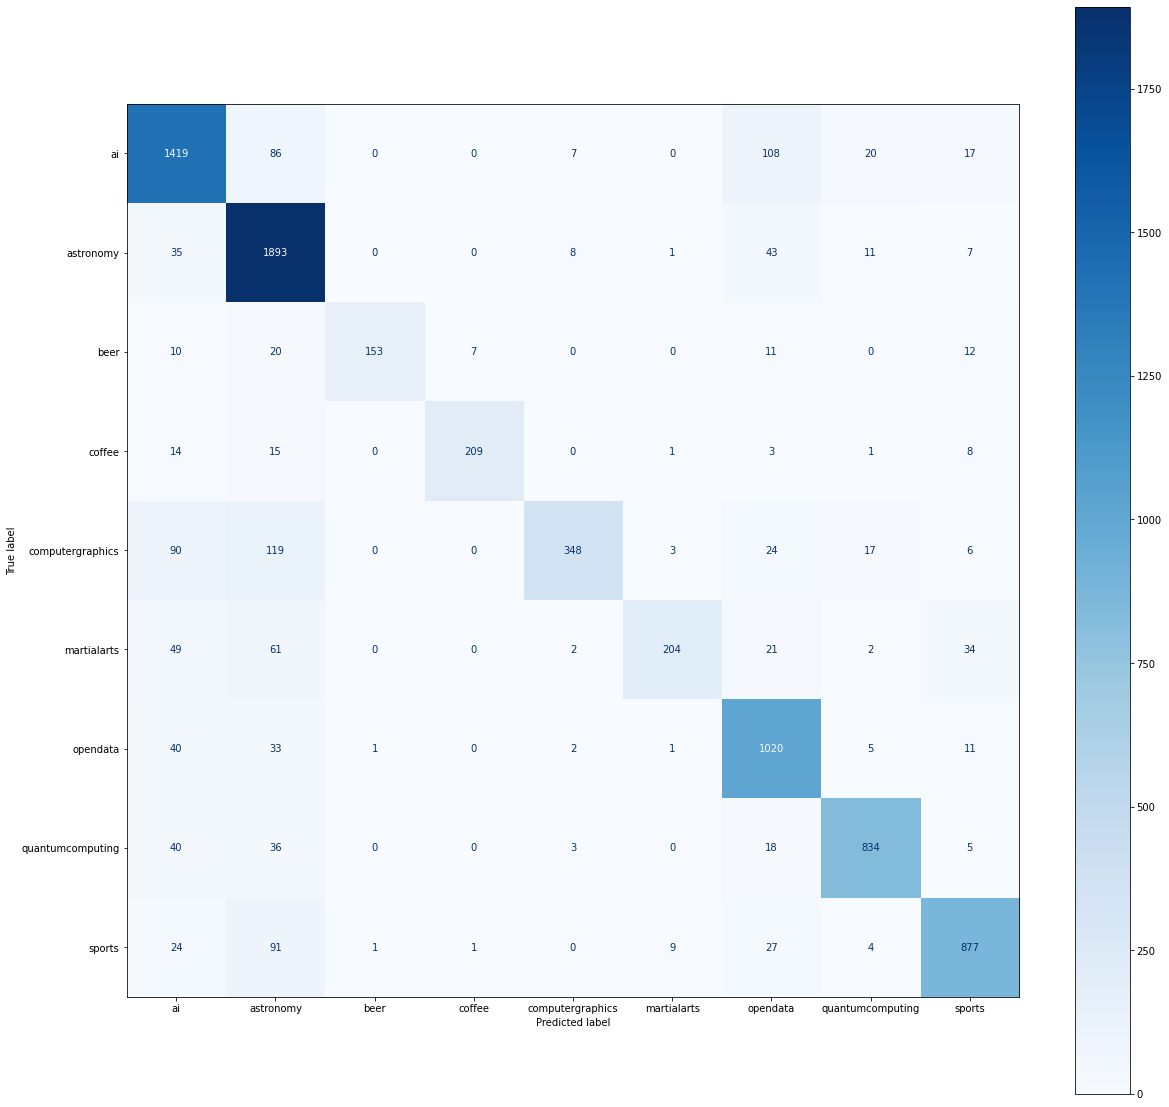

In [152]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 20))
plot_confusion_matrix(svm_grid, X_valid, y_valid, ax= ax, cmap=plt.cm.Blues)  
plt.show()

In [ ]:
## AUTO SKLEARN

In [16]:
from collections import Counter
Counter(y_valid)

Counter({'quantumcomputing': 702,
         'computergraphics': 455,
         'astronomy': 1499,
         'ai': 1243,
         'sports': 776,
         'opendata': 835,
         'martialarts': 279,
         'coffee': 188,
         'beer': 160})

In [18]:
import scipy
print('autosklearn: %s' % scipy.__version__)

autosklearn: 1.8.0


## FAST API METHOD

In [ ]:
# split data into train and validate
X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=0.15,
    random_state=42,
    shuffle=True,
    stratify=y,
)

In [ ]:
# Create a classifier in pipeline
sentiment_classifier = Pipeline(steps=[
                               ('pre_processing',TfidfVectorizer(lowercase=False)),
                                 ('naive_bayes',MultinomialNB())
                                 ])

In [ ]:
sentiment_classifier.fit(X_train,y_train)

In [ ]:
sentiment_classifier.get_params(deep=True)

In [ ]:
y_preds = sentiment_classifier.predict(X_valid)

In [ ]:
accuracy_score(y_valid,y_preds)

In [ ]:
import joblib 
joblib.dump(sentiment_classifier, './sentiment_model_pipeline.pkl')

In [ ]:
# text preprocessing modules
from string import punctuation 
# text preprocessing modules
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re  # regular expression
import os
from os.path import dirname, join, realpath
import joblib
import uvicorn
from fastapi import FastAPI

In [ ]:
app = FastAPI(
    title="Question Souce Model API",
    description="A simple API that uses NLP model to predict the forum to which a question is coming from",
    version="0.1",
)

In [ ]:
# load the sentiment model
with open(
    join("sentiment_model_pipeline.pkl"), "rb"
) as f:
    model = joblib.load(f)

In [ ]:
@app.get("/predict-review")
def predict_sentiment(review: str):
    """
    A simple function that receive a review content and predict the sentiment of the content.
    :param review:
    :return: prediction, probabilities
    """
    # clean the review
    cleaned_review = text_cleaning(review)
    
    # perform prediction
    prediction = model.predict([cleaned_review])
    output = int(prediction[0])
    probas = model.predict_proba([cleaned_review])
    output_probability = "{:.2f}".format(float(probas[:, output]))
    
    # output dictionary
    sentiments = {0: "Negative", 1: "Positive"}
    
    # show results
    result = {"prediction": sentiments[output], "Probability": output_probability}
    return result

In [ ]:
uvicorn main:app --reload

## AUTOML WITH H20

In [ ]:
import h2o
from h2o.automl import H2OAutoML
h2o.init(max_mem_size='8G')
get_ipython().run_line_magic('pinfo', 'h2o.init')

In [ ]:
_data.columns

In [ ]:
raw_data['question'] = raw_data['question'].astype(str)
df = h2o.H2OFrame(raw_data)
df.head()

In [ ]:
d1, d2 = df.split_frame(ratios=[0.75])
# train = splits[0]
# test = splits[1]

y = "forum" 
x = df.columns
x.remove(y)
aml = H2OAutoML(max_runtime_secs=60, 
                balance_classes= True, 
                project_name='doc_classification',
                stopping_metric= 'logloss',
                keep_cross_validation_predictions=True,
                )
%time aml.train(x= x, y=y, training_frame = d1)


In [ ]:
aml.leaderboard